In [1]:
import sys
sys.path.append("../..")

# Noisy Pendulum - Cubature Kalman Filter and Smoother Examples

Estimate pendulum state with CKF and CRTS as in Examples 8.13 and 14.7 of the book

_Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed., Cambridge University Press._

See LICENSE provided with the software.

## Imports

### Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, stats
import tqdm
import json

### Helpers imports

In [3]:
from python.common_utilities import generate_pendulum, RandomState, rmse, plot_pendulum

## Routine

Set the parameters:

In [4]:
dt = 0.01
g  = 9.81

In [5]:
Q  = 0.01 * np.array([[dt ** 3 / 3, dt ** 2 / 2], 
                      [dt ** 2 / 2, dt]])
R  = 0.1

In [6]:
x_0 = np.array([1.5, 0.])

## Load or simulate data

In [7]:
# Simulation
#random_state = RandomState(1)
#steps = 500
#timeline, states, observations = generate_pendulum(x_0, g, Q, dt, R, steps, random_state)

# This loads stored data from file
with open("pendulum.json") as fp:
    jsondata = json.load(fp)
    timeline = np.array(jsondata["T"])
    states = np.array(jsondata["X"]).T
    observations = np.array(jsondata["Y"])
    steps = states.shape[0]

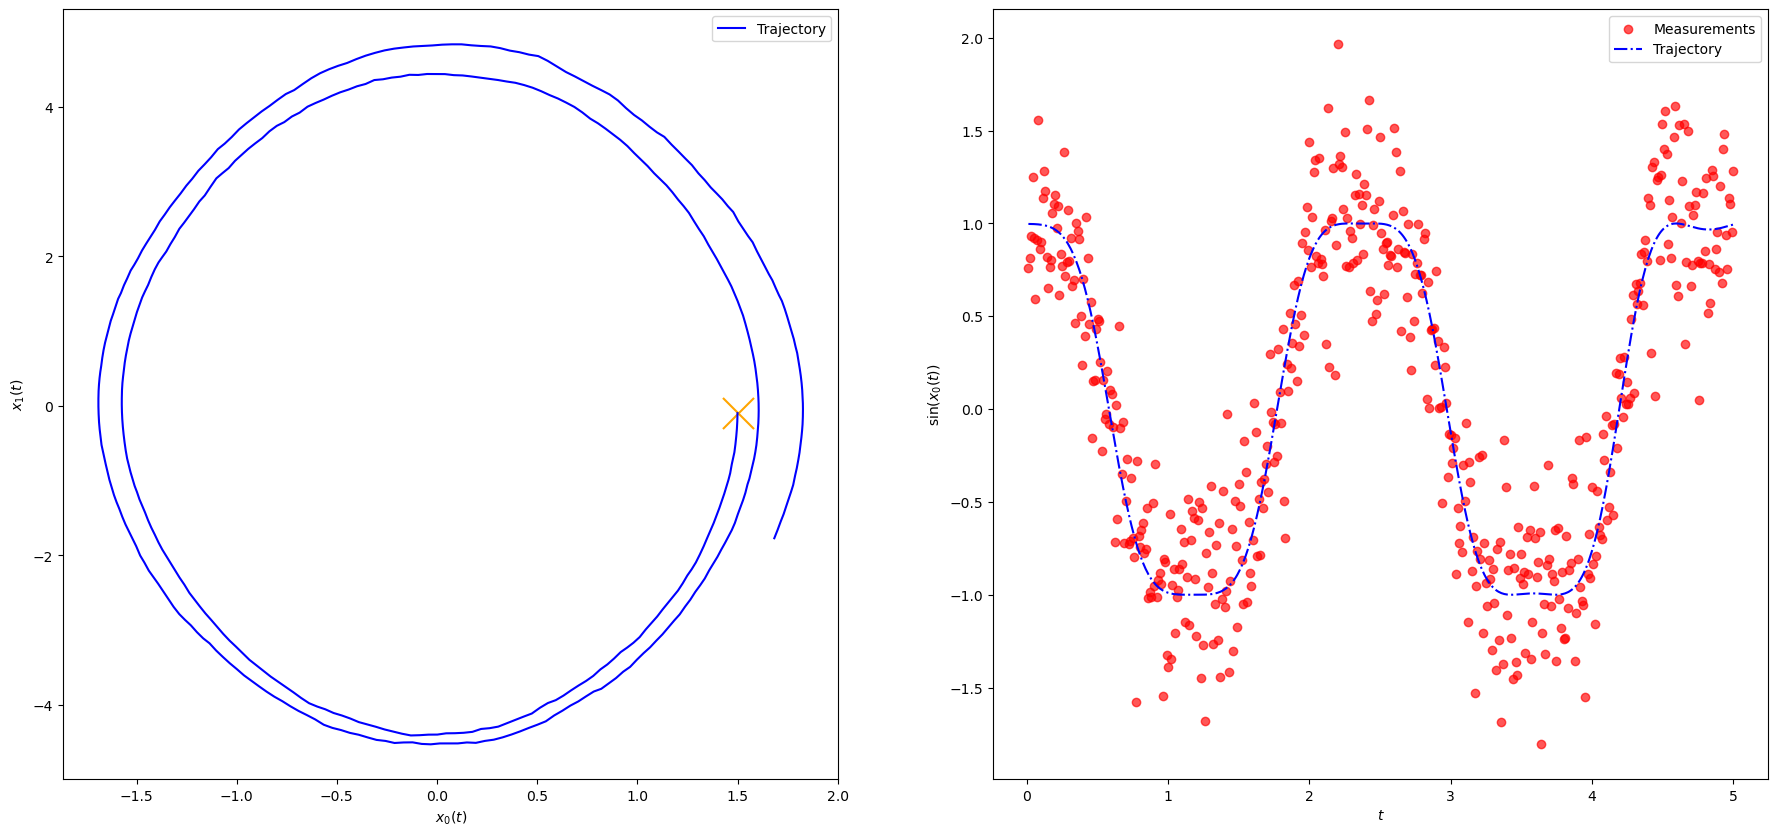

In [8]:
plot_pendulum(timeline, observations, states, "Trajectory")

## Cubature Kalman Filter

In [9]:
#m_0 = np.array([1.6, 0.])  # Slightly off
#P_0 = np.array([[0.1, 0.], 
#                [0., 0.1]])
m_0 = np.array([0.0, 0.0])
P_0 = np.eye(2)

In [10]:
def cubature_kalman_filter(m_0, P_0, g, Q, dt, R, observations):
    # Compute the weights
    n = m_0.shape[-1]
    unit_sigma_points = np.concatenate([np.eye(n), -np.eye(n)]).T * np.sqrt(n)
    weights = np.full(2 * n, 0.5 / n)

    # Initial parameters
    steps = observations.shape[0]
    
    ckf_m = np.empty((steps, n))
    ckf_P = np.empty((steps, n, n))
    
    m = m_0[:]
    P = P_0[:]
    
    # Filtering loop
    for i in range(steps):
        y = observations[i]
        
        # Compute the sigma points for the dynamics
        L = np.linalg.cholesky(P)
        sigma_points = L @ unit_sigma_points + m.reshape(-1, 1)
        
        # Progagate through the dynamics
        sigma_points[0, :], sigma_points[1, :] = sigma_points[0, :] + dt * sigma_points[1, :], sigma_points[1, :] - g * dt * np.sin(sigma_points[0, :])        
        
        # Predicted state distribution
        m = np.dot(sigma_points, weights)
        P = np.dot(weights.reshape(1, -1) * (sigma_points - m.reshape(-1, 1)), (sigma_points - m.reshape(-1, 1)).T) + Q

        # Compute the sigma points for the observation
        L = np.linalg.cholesky(P)
        sigma_points = L @ unit_sigma_points + m.reshape(-1, 1)
        
        # Progagate through the measurement model
        sigma_observations = np.sin(sigma_points[0, :])
        
        # sigma points measurement mean and covariance
        predicted_mu = np.dot(sigma_observations, weights)
        predicted_cov = np.dot(weights * (sigma_observations - predicted_mu), sigma_observations - predicted_mu) + R
        cross_cov = np.dot(sigma_points - m.reshape(-1, 1), weights * (sigma_observations - predicted_mu))
        
        # Gain and updated mean and covariance
        K = cross_cov / predicted_cov  # Works only when predicted_cov is scalar
        m = m + K * (y - predicted_mu) # Optimized for the scalar case as well as the following
        P = P - predicted_cov * K.reshape(-1, 1) * K
        
        ckf_m[i] = m
        ckf_P[i] = P
    return ckf_m, ckf_P

In [11]:
ckf_m, ckf_P = cubature_kalman_filter(m_0, P_0, g, Q, dt, R, observations)

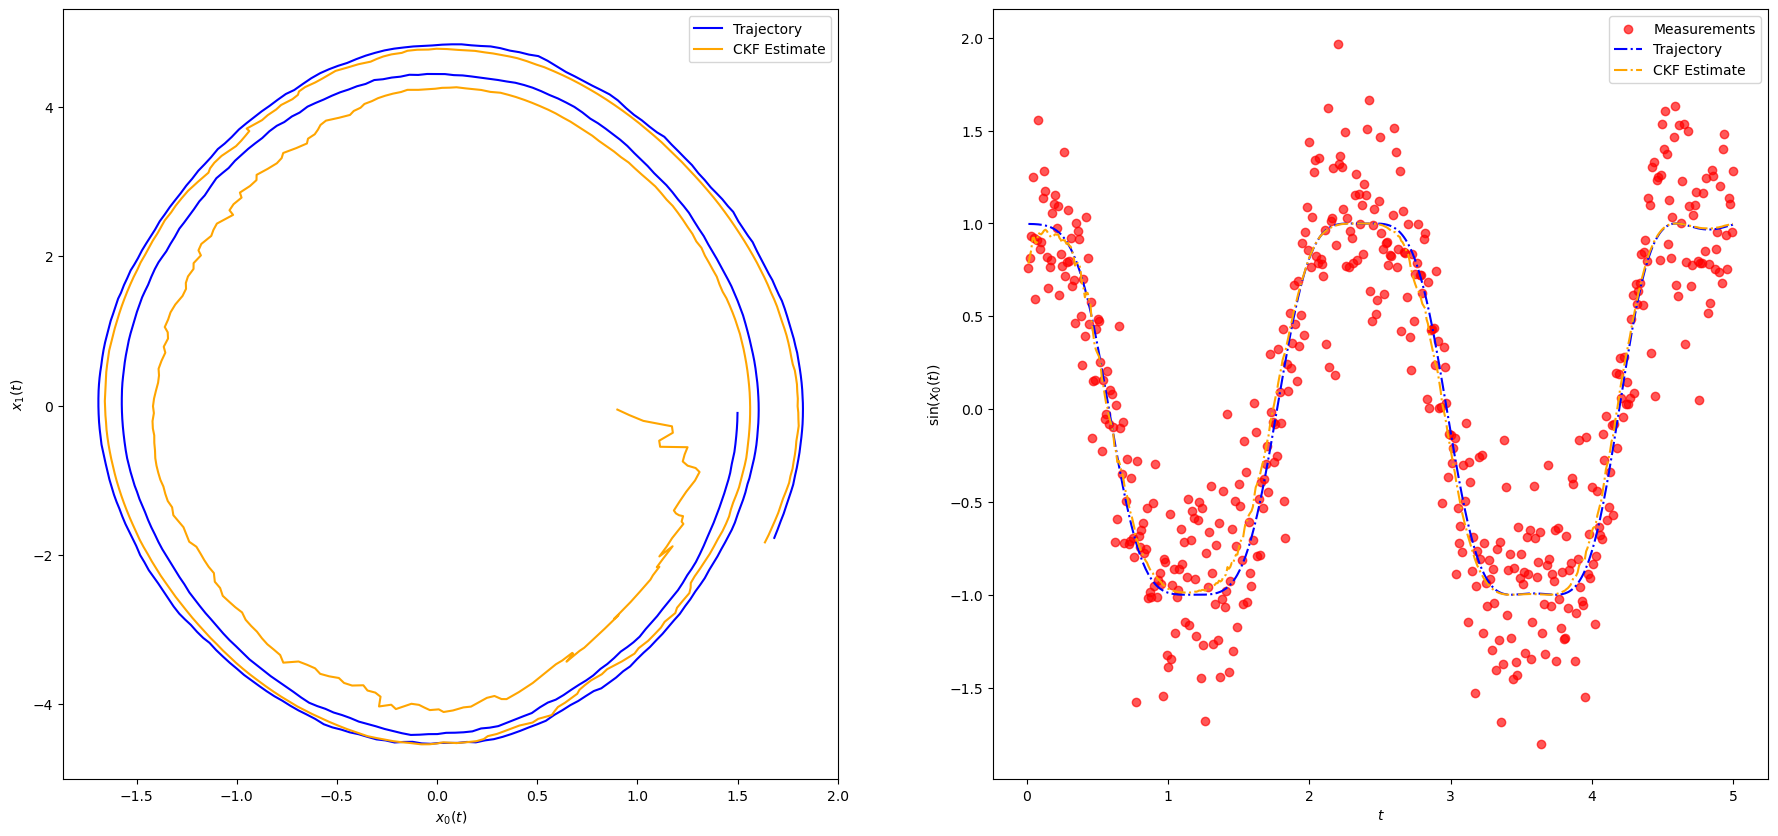

In [12]:
plot_pendulum(timeline, observations, states, "Trajectory", ckf_m, "CKF Estimate")

In [13]:
rmse_ckf = rmse(ckf_m[:, :1], states[:, :1])
print(f"CKF RMSE: {rmse_ckf}")

CKF RMSE: 0.1141966031380275


## Cubature RTS

In [14]:
def cubature_smoother(ckf_m, ckf_P, g, Q, dt):
    steps, n = ckf_m.shape
    
    # Compute the weights
    unit_sigma_points = np.concatenate([np.eye(n), -np.eye(n)]).T * np.sqrt(n)
    weights = np.full(2 * n, 0.5 / n)

    # Initialize    
    rts_m = np.empty((steps, n))
    rts_P = np.empty((steps, n, n))
    
    m = ckf_m[-1]
    P = ckf_P[-1]
    
    rts_m[-1] = m
    rts_P[-1] = P
    
    zeros = np.zeros((n, 1))
    
    # Smoothing loop
    for i in range(steps-2, -1, -1):
        filtered_m = ckf_m[i]
        filtered_P = ckf_P[i]
        
        # Compute the sigma points for the dynamics
        L = np.linalg.cholesky(filtered_P)
        sigma_points = L @ unit_sigma_points + filtered_m.reshape(-1, 1)
        
        # Progagate through the dynamics
        propagated_points = np.stack([sigma_points[0, :] + dt * sigma_points[1, :], 
                                      sigma_points[1, :] - g * dt * np.sin(sigma_points[0, :])])
        
        # Predicted state distribution
        mp = np.dot(propagated_points, weights)
        Pp = np.dot(weights.reshape(1, -1) * (propagated_points - mp.reshape(-1, 1)), (propagated_points - mp.reshape(-1, 1)).T) + Q
        D = np.dot(weights * (sigma_points - filtered_m.reshape(-1, 1)), (propagated_points - mp.reshape(-1, 1)).T)  # cross-covariance
        
        # More efficient and stable way of computing Gk = D @ linalg.inv(Pp)
        # This also leverages the fact that Pp is known to be a positive definite matrix (assume_a="pos")
        Gk = linalg.solve(Pp, D.T, assume_a="pos").T 

        m = filtered_m + Gk @ (m - mp)
        P = filtered_P + Gk @ (P - Pp) @ Gk.T
        
        rts_m[i] = m
        rts_P[i] = P

    return rts_m, rts_P


In [15]:
rts_m, rts_P = cubature_smoother(ckf_m, ckf_P, g, Q, dt)

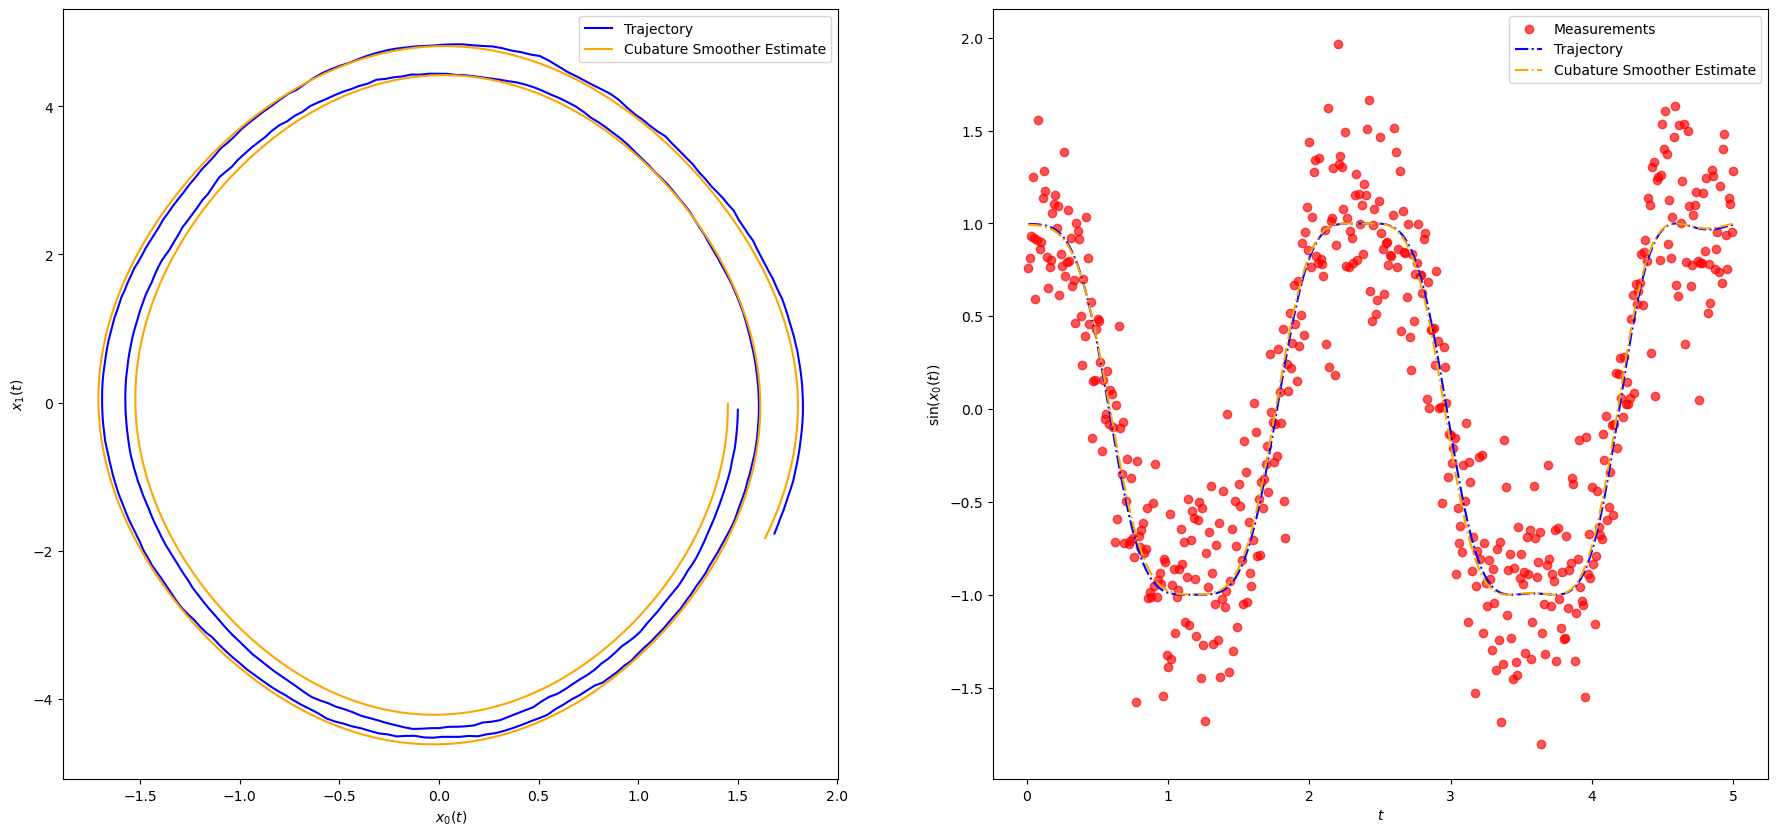

In [16]:
plot_pendulum(timeline, observations, states, "Trajectory", rts_m, "Cubature Smoother Estimate")

In [17]:
rmse_crts = rmse(rts_m[:, :1], states[:, :1])
print(f"CRTS RMSE: {rmse_crts}")

CRTS RMSE: 0.04064624229594188
